# XgBoost Classifier for Predicting PV energy generation   

In [1]:
# Data manipulation and processing
import pandas as pd
import numpy as np

# Machine learning and model evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# XGBoost model
from xgboost import XGBRegressor

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # SHAP library for feature importance analysis

# Performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt



## Loading preprocessed data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load the data
data = pd.read_csv('solar_data_with_temperature_adjusted_irradiance.csv')

# Step 2: Separate the features (X) and the target (y)
X = data[['GHI', 'DNI', 'DHI', 'Temperature']]  # Features
y = data['Tilted Irradiance (Adjusted)']  # Target

print(X)
print(y)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Save the train and test sets as CSV files
train_data = pd.concat([X_train, y_train], axis=1)  # Combine X_train and y_train
test_data = pd.concat([X_test, y_test], axis=1)  # Combine X_test and y_test

# Save to CSV files
train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)

# Print out the first few rows to verify
print("Training Data Head:")
print(train_data.head())
print("\nTesting Data Head:")
print(test_data.head())



      GHI  DNI  DHI  Temperature
0       0    0    0          8.6
1       0    0    0          9.4
2       0    0    0         10.1
3       0    0    0         10.6
4       0    0    0         11.4
...   ...  ...  ...          ...
8755    0    0    0          6.1
8756    0    0    0          6.6
8757    0    0    0          6.9
8758    0    0    0          7.4
8759    0    0    0          8.0

[8760 rows x 4 columns]
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8755    0.0
8756    0.0
8757    0.0
8758    0.0
8759    0.0
Name: Tilted Irradiance (Adjusted), Length: 8760, dtype: float64
Training Data Head:
      GHI  DNI  DHI  Temperature  Tilted Irradiance (Adjusted)
8415   10    0   10          1.2                      9.264222
5049  731  759  145         29.8                    772.181593
8395    0    0    0          1.3                      0.000000
1535    0    0    0         -6.0                      0.000000
5518    0    0    0         23.8               

## Creating trasforming pipelines 

In [3]:
# Step 5: Define numerical and categorical columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()  # Numerical features
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()  # Categorical features

# Step 6: Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Scale numerical features
        ('cat', 'passthrough', categorical_columns)  # Keep categorical features as is
    ]
)

## Initializing XGBoost model

In [4]:
# Step 7: Initialize the XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Step 8: Create the final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', xgb_model)
])

# Step 9: Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
}


# Initialize and fit GridSearchCV
grid_search = GridSearchCV(estimator=final_pipeline,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  # Use MSE for regression
                           cv=3,  # Number of cross-validation folds
                           verbose=1,
                           n_jobs=-1)  # Use all available cores



## Hyperparameter tuning using GridSearchCV

In [5]:
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Step 11: Best model after Grid Search
best_model = grid_search.best_estimator_

# Step 12: Make predictions with the best model
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


## Plotting results

Training Predictions: [ 9.2211380e+00  7.7262915e+02  1.0596332e-01 -3.5832033e-02
  1.6350321e-01 -1.0750960e-01  7.7763535e-02  1.4728122e+02
 -1.0750960e-01  1.9532824e-02]
Test Predictions: [ 6.2973171e+01  6.5825079e+02  5.1845734e+02  8.9820161e-02
  2.0394324e+02 -1.3369982e-01 -9.2580549e-02 -1.0866807e-01
  4.5748181e+02 -9.7550981e-02]


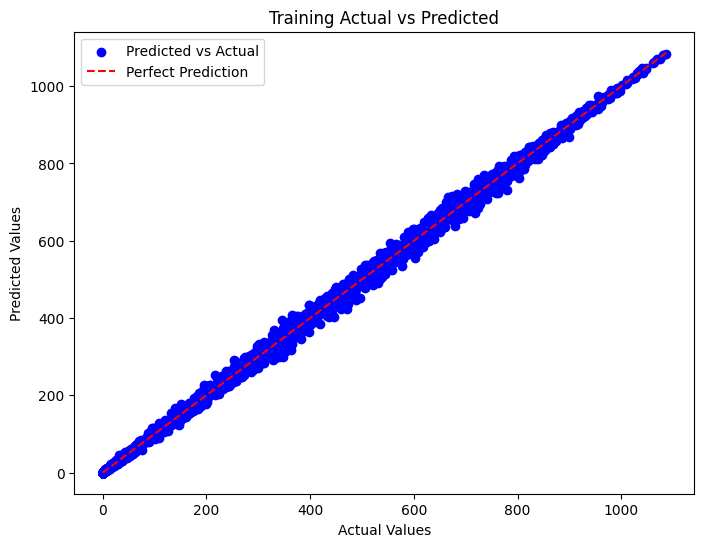

Training Regression Metrics:
  Mean Squared Error (MSE): 54.9858
  R² Score: 0.9994


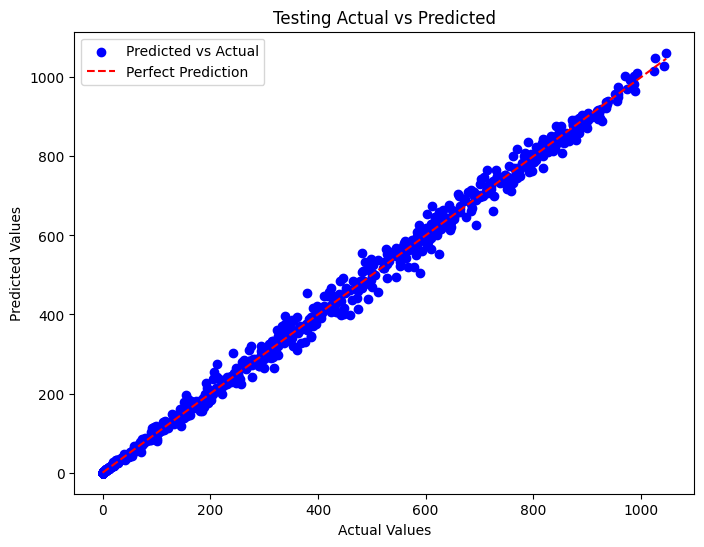

Testing Regression Metrics:
  Mean Squared Error (MSE): 154.1035
  R² Score: 0.9981
Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
Best Score: -169.88057509228608


In [6]:
# Step 13: Print predictions for the first 10 samples in training and testing
print(f"Training Predictions: {train_preds[:10]}")
print(f"Test Predictions: {test_preds[:10]}")

# Function to plot Actual vs Predicted Values
def plot_actual_vs_predicted(true_values, predictions, set_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(true_values, predictions, color='blue', label='Predicted vs Actual')
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{set_name} Actual vs Predicted')
    plt.legend()
    plt.show()

# Function to print regression metrics
from sklearn.metrics import mean_squared_error, r2_score

def print_regression_metrics(true_values, predictions, set_name):
    mse = mean_squared_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    print(f"{set_name} Regression Metrics:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  R² Score: {r2:.4f}")

# Visualize and print reports for both sets
plot_actual_vs_predicted(y_train, train_preds, "Training")
print_regression_metrics(y_train, train_preds, "Training")
plot_actual_vs_predicted(y_test, test_preds, "Testing")
print_regression_metrics(y_test, test_preds, "Testing")

# Step 14: Print best parameters from Grid Search
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


### Analysing feature importance using SHAP library

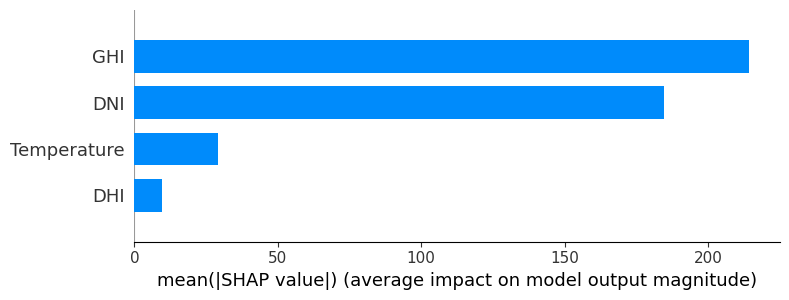

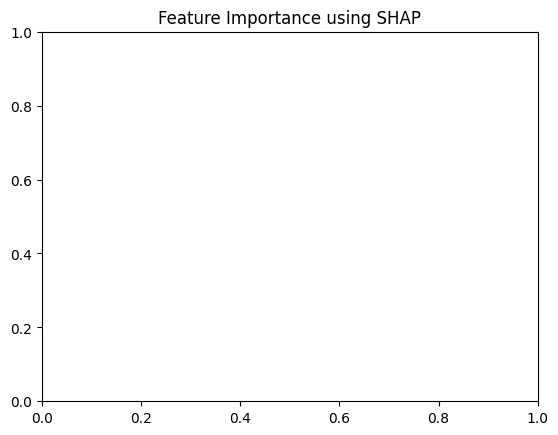

In [7]:
# Step 17: SHAP Values Calculation for Feature Importance
explainer = shap.Explainer(best_model.named_steps['regressor'])
shap_values = explainer(X_train)  # Calculate SHAP values for the training set

# SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.title("Feature Importance using SHAP")
plt.show()

### **Conclusion**

In this study, we used the **XGBRegressor** model to predict the target variable based on a set of features, and evaluated its performance using key regression metrics on both the training and test datasets.

#### **Training Performance:**
The model achieved an exceptional **R² score of 0.9994** on the training dataset, indicating that it explains **99.94%** of the variance in the target variable. This suggests that the model fits the training data nearly perfectly and captures the underlying patterns effectively. The **Mean Squared Error (MSE)** on the training data was **54.9858**, which is relatively low, though its significance depends on the scale of the target variable. In general, a lower MSE indicates that the model’s predictions are close to the true values.

#### **Test Performance:**
When evaluating the model on the unseen test data, we observed that the model's performance remained strong, with an **R² score** of **0.9981** and an **MSE** of **154.1035**. While the test R² is slightly lower than the training R², the model still accounts for more than 99% of the variance in the target variable, demonstrating its strong generalization capability. The increase in MSE on the test data is expected and typical in machine learning, as models often perform slightly worse on new, unseen data due to the inherent noise and variability present in real-world datasets.

#### **Model Generalization:**
The fact that the model maintained a high R² score on the test data suggests that it is not overfitting to the training set and is able to generalize well to new, unseen data. This is further validated by the relatively small difference in performance between the training and testing sets, implying that the model is robust and not overly complex or specialized to the training data.

#### **Implications and Future Work:**
The high **R²** and low **MSE** suggest that the model performs exceptionally well for this task. However, it is important to evaluate the model's performance across different subsets of the data through techniques like cross-validation to ensure that it performs consistently across all scenarios. Future work could explore further hyperparameter tuning and the inclusion of additional features or data sources to further enhance the model's predictive power. Moreover, an examination of the model's residuals and prediction error distribution could provide more insights into areas where the model may be underperforming or biased.

In conclusion, the **XGBRegressor** model demonstrates strong predictive performance, with the ability to accurately predict the target variable in both training and testing datasets. The results indicate that the model is highly effective and can be leveraged for predictive tasks in similar contexts.
